# Imports

In [1]:
import string
import shutil
import torch
import random
import math
import h5py
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.optim import lr_scheduler
from google.colab import drive
from google.colab import runtime
from tqdm import tqdm
from itertools import combinations
from torch.utils.data import BatchSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
from torchvision import models, transforms
from torchvision.transforms import v2
from torchsummary import summary
from torchvision.datasets import MNIST
from torchvision import transforms
!pip install audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, TimeMask

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 2.0 MB/s eta 0:00:00
Mounted at /content/drive


# Data

Loading Data

In [2]:
with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/train_data.h5', 'r') as train_file:
    train_data = np.array(train_file['data'])
    train_labels = np.array(train_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/val_data.h5', 'r') as val_file:
    val_data = np.array(val_file['data'])
    val_labels = np.array(val_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/test_data.h5', 'r') as test_file:
    test_data = np.array(test_file['data'])
    test_labels = np.array(test_file['labels'])

Balanced Batch Sampler

In [24]:
# From https://github.com/adambielski/siamese-triplet
class BalancedBatchSampler(BatchSampler):
    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(self.labels == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

Data Augmentation

In [4]:
class DataAugmentation(nn.Module):
    def __init__(self):
        super(DataAugmentation, self).__init__()
        self.transforms = Compose([
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
            TimeMask(min_band_part=0.1, max_band_part=0.15, p=0.5),
        ])

    def forward(self, song, sample_rate):
        augmented_song = self.transforms(song, sample_rate=sample_rate)
        return augmented_song

Create Dataset

In [25]:
class AudioDataset(Dataset):
    def __init__(self, input_data, input_labels, sample_rate=16000, n_mels=128, mean=6.5304, std=11.8924, transform=None):
        self.input_data = input_data
        self.input_labels = input_labels
        self.sr = sample_rate
        self.n_mels = n_mels
        self.mean = mean
        self.std = std
        self.transform = transform
        self.mel_spec_transform = T.MelSpectrogram(sample_rate=self.sr, n_mels=self.n_mels, n_fft=2048, hop_length=512)
        self.log_mel_spec_transform = T.AmplitudeToDB()
        self.image_transforms = transform = v2.Compose([
                                                        v2.Resize((64, 64)),
                                                        v2.ToImage(),
                                                        v2.ToDtype(torch.float32, scale=True),
                                                        v2.Normalize((self.mean,), (self.std,))
                                                    ])

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        song = self.input_data[idx]
        genre = self.input_labels[idx]
        if self.transform:
            song = self.transform(song, self.sr)

        mel_spec = self.mel_spec_transform(torch.from_numpy(song))
        log_mel_spec = self.log_mel_spec_transform(mel_spec)
        mel_spec_tensor = log_mel_spec.unsqueeze(0)
        mel_spec_tensor = self.image_transforms(mel_spec_tensor)

        return mel_spec_tensor, genre


audio_train_dataset = AudioDataset(input_data=train_data, input_labels=train_labels, transform=None)
audio_val_dataset = AudioDataset(input_data=val_data, input_labels=val_labels, transform=None)

train_batch_sampler = BalancedBatchSampler(audio_train_dataset.input_labels, n_classes=8, n_samples=66)
val_batch_sampler = BalancedBatchSampler(audio_val_dataset.input_labels, n_classes=8, n_samples=66)

audio_train_loader = DataLoader(audio_train_dataset, batch_sampler=train_batch_sampler,pin_memory=True)
audio_val_loader = DataLoader(audio_val_dataset, batch_sampler=val_batch_sampler, pin_memory=True)

In [6]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

def get_mean_std(data):
  mean = np.mean(data, axis=(0, 1, 2))
  std = np.std(data, axis=(0, 1, 2))
  return mean, std

# Model

Print Layer (debugging)

In [7]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print("X shape:", x.shape)
        return x


Positional Encoding

In [8]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding1d(nn.Module):
    def __init__(self, d_model, length):
        super(PositionalEncoding1d, self).__init__()
        if d_model % 2 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dim (got dim={:d})".format(d_model))
        pe = torch.zeros(length, d_model)
        position = torch.arange(0, length).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                            -(math.log(10000.0) / d_model)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe


class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [9]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class SeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1, bias=False):
        super(SeparableConv1d, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Residual Block

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool, two_dim: bool):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short
        self.two_dim = two_dim

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 1):
            if self.two_dim:
              layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False))
            else:
              layers.append(SeparableConv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            if self.two_dim:
              self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
              self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
            else:
              self.pool = nn.MaxPool1d(kernel_size=kernel_size, stride=2, padding=1)
              self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        else:
            if self.two_dim:
              self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
            else:
              self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.pool(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

Embedding Model

In [11]:
class EmbeddingModel(nn.Module):
    def __init__(self):
      super(EmbeddingModel, self).__init__()
      self.input = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
                                 nn.SELU())
      self.positional_encoding = PositionalEncoding2d(64, 128, 130)


      self.conv_layers = nn.Sequential(
          ResidualBlock(in_channels=64, out_channels=64, kernel_size=3, num_layers=4, pool=True, short=True, two_dim=True),
          ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, num_layers=4, pool=True, short=True, two_dim=True),
          ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, num_layers=4, pool=True, short=True, two_dim=True),
      )

      self.attention = nn.MultiheadAttention(embed_dim=16, num_heads=2, dropout=0.5, batch_first=True)

      self.dense_layers = nn.Sequential(
          nn.Linear(in_features=256, out_features=512, bias=False),
          nn.SELU(),
          nn.Linear(in_features=512, out_features=256, bias=False),
          nn.SELU(),
          nn.Linear(in_features=256, out_features=128, bias=False),
          nn.SELU(),
          nn.Dropout(0.5),
      )

      self.output = nn.Linear(128, 2)

    def forward(self, x):
      x = self.input(x)
      # x = F.layer_norm(self.positional_encoding(x), x.shape)
      x = self.conv_layers(x)

      # batch_size, channels, height, width = x.size()
      # x = x.view(batch_size, channels, height * width)
      # attention_output, _ = self.attention(x, x, x)
      # x = F.layer_norm(x + attention_output, x.shape)

      x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
      x = self.dense_layers(x)
      out = self.output(x)
      return out

    def get_embedding(self, x):
      return self.forward(x)

In [12]:
# From https://github.com/adambielski/siamese-triplet
class SimpleEmbeddingModel(nn.Module):
    def __init__(self):
        super(SimpleEmbeddingModel, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5),
                                     nn.SELU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5),
                                     nn.SELU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(64, 128, 5),
                                     nn.SELU(),
                                     nn.MaxPool2d(2, stride=2)
                                    )

        self.fc = nn.Sequential(nn.Linear(2048, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

# Utils

In [13]:
class HardTripletLoss(nn.Module):
    """Hard/Hardest Triplet Loss
    (pytorch implementation of https://omoindrot.github.io/triplet-loss)

    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    """
    def __init__(self, margin=0.1, hardest=False, squared=False):
        """
        Args:
            margin: margin for triplet loss
            hardest: If true, loss is considered only hardest triplets.
            squared: If true, output is the pairwise squared euclidean distance matrix.
                If false, output is the pairwise euclidean distance matrix.
        """
        super(HardTripletLoss, self).__init__()
        self.margin = margin
        self.hardest = hardest
        self.squared = squared

    def forward(self, embeddings, labels):
        """
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)

        Returns:
            triplet_loss: scalar tensor containing the triplet loss
        """
        pairwise_dist = _pairwise_distance(embeddings, squared=self.squared)

        if self.hardest:
            # Get the hardest positive pairs
            mask_anchor_positive = _get_anchor_positive_triplet_mask(labels).float()
            valid_positive_dist = pairwise_dist * mask_anchor_positive
            hardest_positive_dist, _ = torch.max(valid_positive_dist, dim=1, keepdim=True)

            # Get the hardest negative pairs
            mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
            max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
            anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (
                    1.0 - mask_anchor_negative)
            hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

            # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
            triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + self.margin)
            triplet_loss = torch.mean(triplet_loss)
        else:
            anc_pos_dist = pairwise_dist.unsqueeze(dim=2)
            anc_neg_dist = pairwise_dist.unsqueeze(dim=1)

            # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
            # triplet_loss[i, j, k] will contain the triplet loss of anc=i, pos=j, neg=k
            # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
            # and the 2nd (batch_size, 1, batch_size)
            loss = anc_pos_dist - anc_neg_dist + self.margin

            mask = _get_triplet_mask(labels).float()
            triplet_loss = loss * mask

            # Remove negative losses (i.e. the easy triplets)
            triplet_loss = F.relu(triplet_loss)

            # Count number of hard triplets (where triplet_loss > 0)
            hard_triplets = torch.gt(triplet_loss, 1e-16).float()
            num_hard_triplets = torch.sum(hard_triplets)

            triplet_loss = torch.sum(triplet_loss) / (num_hard_triplets + 1e-16)

        return triplet_loss


def _pairwise_distance(x, squared=False, eps=1e-16):
    # Compute the 2D matrix of distances between all the embeddings.

    cor_mat = torch.matmul(x, x.t())
    norm_mat = cor_mat.diag()
    distances = norm_mat.unsqueeze(1) - 2 * cor_mat + norm_mat.unsqueeze(0)
    distances = F.relu(distances)

    if not squared:
        mask = torch.eq(distances, 0.0).float()
        distances = distances + mask * eps
        distances = torch.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    # Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    indices_not_equal = torch.eye(labels.shape[0]).to(device).byte() ^ 1

    # Check if labels[i] == labels[j]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)

    mask = indices_not_equal * labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels):
    # Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    # Check if labels[i] != labels[k]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    mask = labels_equal ^ 1

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.

    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Check that i, j and k are distinct
    indices_not_same = torch.eye(labels.shape[0]).to(device).byte() ^ 1
    i_not_equal_j = torch.unsqueeze(indices_not_same, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_same, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_same, 0)
    distinct_indices = i_not_equal_j * i_not_equal_k * j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = i_equal_j * (i_equal_k ^ 1)

    mask = distinct_indices * valid_labels   # Combine the two masks

    return mask

Online Triplet Loss

In [14]:
# From https://github.com/adambielski/siamese-triplet
class OnlineTripletLoss(nn.Module):
    def __init__(self, margin):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings, target, triplet_selector):
        triplets = triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        ap_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 1]]).pow(2).sum(1)
        an_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 2]]).pow(2).sum(1)
        triplet_loss = F.relu(ap_distances - an_distances + self.margin)

        return triplet_loss.mean(), len(triplets)

Triplet Mining

In [15]:
# From https://github.com/adambielski/siamese-triplet
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

def random_value(loss_values):
    return np.random.choice(loss_values)

def random_hard_value(loss_values):
    hard_value = np.where(loss_values > 0)[0]
    return np.random.choice(hard_value) if len(hard_value) > 0 else None

def easiest_positive(loss_values):
    easy_positive = np.argmin(loss_values)
    return easy_positive if loss_values[easy_positive] > 0 else None

def hardest_positive(loss_values):
    hard_positive = np.argmax(loss_values)
    return hard_positive if loss_values[hard_positive] > 0 else None

def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None

def hardest_negative(loss_values):
    hard_negative = np.argmin(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None

In [16]:
# From https://github.com/adambielski/siamese-triplet
class TripletSelector:
    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError

class SingleNegativeTripletSelector(TripletSelector):
    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(SingleNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]] + self.margin

            idxs = np.ix_(anchor_positives[:, 0], negative_indices)
            loss_values = ap_distances.unsqueeze(dim=1) - distance_matrix[idxs]
            loss_values = loss_values.data.cpu().numpy()
            for i, loss_val in enumerate(loss_values):
                hard_negative = self.negative_selection_fn(loss_val)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positives[i][0], anchor_positives[i][1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positives[-1][0], anchor_positives[-1][1], negative_indices[0]])

        return torch.LongTensor(triplets)

def HardestTripletSelector(margin, cpu=False): return SingleNegativeTripletSelector(margin=margin,
                                                                                 negative_selection_fn=hardest_negative,
                                                                                 cpu=cpu)

def HardTripletSelector(margin, cpu=False): return SingleNegativeTripletSelector(margin=margin,
                                                                                 negative_selection_fn=random_hard_value,
                                                                                 cpu=cpu)


def SemiHardTripletSelector(margin, cpu=False): return SingleNegativeTripletSelector(margin=margin,
                                                                                  negative_selection_fn=lambda x: semihard_negative(x, margin),
                                                                                  cpu=cpu)

In [17]:
# class DoubleNegativeTripletSelector(TripletSelector):
#     def __init__(self, margin, negative_selection_fn, positive_selection_fn, cpu=True):
#         super(DoubleNegativeTripletSelector, self).__init__()
#         self.cpu = cpu
#         self.margin = margin
#         self.positive_selection_fn = positive_selection_fn

#     def set_pos_function(self, positive_selection_fn):
#         self.positive_selection_fn = positive_selection_fn

#     def set_neg_function(self, negative_selection_fn):
#         self.negative_selection_fn = negative_selection_fn

#     def get_triplets(self, embeddings, labels):
#         if self.cpu:
#             embeddings = embeddings.cpu()
#         distance_matrix = pdist(embeddings)
#         distance_matrix = distance_matrix.cpu()

#         labels = labels.cpu().data.numpy()
#         triplets = []

#         for label in set(labels):
#             label_mask = (labels == label)
#             positive_indices = np.where(label_mask)[0]
#             negative_indices = np.where(np.logical_not(label_mask))[0]

#             for anchor_positive in positive_indices:
#                 ap_distance = distance_matrix[torch.LongTensor(np.array([anchor_positive])), torch.LongTensor(positive_indices)]
#                 an_distance = distance_matrix[torch.LongTensor(np.array([anchor_positive])), torch.LongTensor(negative_indices)]
#                 loss_values = ap_distance - an_distance + self.margin
#                 loss_values = loss_values.data.cpu().numpy()

#                 selected_negative = self.negative_selection_fn(loss_values)
#                 selected_positive = self.positive_selection_fn(loss_values)
#                 if selected_negative is not None:
#                     selected_negative = negative_indices[selected_negative]
#                     triplets.append([anchor_positive, selected_positive, selected_negative])

#         if len(triplets) == 0:
#             triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

#         triplets = np.array(triplets)

#         return torch.LongTensor(triplets)

# def NewSemiHardTripletSelector(margin, cpu=False): return DoubleNegativeTripletSelector(margin=margin,
#                                                                                   negative_selection_fn=lambda x: semihard_negative(x, margin),
#                                                                                   positive_selection_fn=easiest_positive,
#                                                                                   cpu=cpu)

In [18]:
class AverageNonzeroTripletsMetric():
    def __init__(self):
        self.values = []

    def add(self, loss):
        self.values.append(loss)

    def reset(self):
        self.values = []

    def value(self):
        return np.mean(self.values)

    def name(self):
        return 'Average nonzero triplets'

Early Stopping

In [19]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def reset_loss(self):
        self.min_validation_loss = float('inf')

Autoclip

In [20]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

# Training Loop

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = torch.cuda.is_available()
embedding_model = EmbeddingModel().to(device)
simple_embedding_model = SimpleEmbeddingModel().to(device)

num_epochs = 20
learning_rate = 1e-4
margin = 0.5

loss_fn = HardTripletLoss(margin)
online_mining_loss_fn = OnlineTripletLoss(margin)
triplet_selector = SemiHardTripletSelector(margin)

optimizer = optim.AdamW(embedding_model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=4)
early_stopping = EarlyStopping(patience=3)
scaler = torch.cuda.amp.GradScaler()
autoclipper = AutoClip(percentile=10)
nonzero_triplet_metric = AverageNonzeroTripletsMetric()

def train_loop(train_loader, model, criterion, optimizer, device, epoch, metric, triplet_selector=None):
    metric.reset()
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    # Training loop
    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
          outputs = model(inputs)
          loss = criterion(outputs, targets, triplet_selector)

        train_loss += loss[0].item()
        metric.add(loss[1])
        scaler.scale(loss[0]).backward()
        autoclipper(model)

        scaler.step(optimizer)
        scale = scaler.get_scale()
        scaler.update()
        skip_lr_sched = (scale != scaler.get_scale())

    train_loss = train_loss / num_batches
    return train_loss, metric.value(), skip_lr_sched

def val_loop(val_loader, model, criterion, device, epoch, metric, triplet_selector=None):
    metric.reset()
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets, triplet_selector)
            val_loss += loss[0].item()
            metric.add(loss[1])

    val_loss = val_loss / num_batches
    return val_loss, metric.value()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss, train_nonzero_triplets, skip_lr_sched = train_loop(audio_train_loader, embedding_model, online_mining_loss_fn, optimizer, device, epoch+1, nonzero_triplet_metric, triplet_selector)
    val_loss, val_nonzero_triplets = val_loop(audio_val_loader, embedding_model, online_mining_loss_fn, device, epoch+1, nonzero_triplet_metric, triplet_selector)
    print(f"Train loss: {train_loss:>8f} - Val loss: {val_loss:>8f} \n")
    print(f"Train average nonzero triplets: {train_nonzero_triplets:>8f} - Val average nonzero triplets: {val_nonzero_triplets:>8f} \n")

    # early_stop_result = early_stopping.early_stop(val_loss)
    # if early_stop_result:
    #     print(f"Early stopping after {epoch+1} epochs \n")
    #     print(f"Best val loss: {early_stopping.min_validation_loss} \n")
    #     break

    if not skip_lr_sched:
        scheduler.step()

    # if (epoch + 1 == 20):
    #     triplet_selector = HardTripletSelector(margin, cpu=True)

    # if (epoch + 1 == 40):
    #     triplet_selector = HardestTripletSelector(margin, cpu=True)

    # early_stop_result = early_stopping.early_stop_switch(val_loss)
    # if early_stop_result == 'SWITCH_HM':
    #     break
    #     print("Switching to Hardest Negative Mining\n")
    #     triplet_selector = HardestNegativeTripletSelector(margin, cpu=True)
    # elif early_stop_result == 'EARLY_STOP':
    #     print(f"Early stopping after {epoch+1} epochs \n")
    #     print(f"Best val loss before hardest negative mining: {early_stopping.pre_hm_min_validation_loss} \n")
    #     print(f"Best val loss: {early_stopping.min_validation_loss} \n")
    #     break


Epoch 1
-------------------------------


 99%|█████████▉| 107/108 [02:32<00:01,  1.42s/it]


Train loss: 0.260891 - Val loss: 0.258144 

Train average nonzero triplets: 14202.785047 - Val average nonzero triplets: 14154.307692 

Epoch 2
-------------------------------


 99%|█████████▉| 107/108 [02:25<00:01,  1.36s/it]


Train loss: 0.251833 - Val loss: 0.256615 

Train average nonzero triplets: 12477.682243 - Val average nonzero triplets: 10885.461538 

Epoch 3
-------------------------------


 99%|█████████▉| 107/108 [02:24<00:01,  1.35s/it]


Train loss: 0.250466 - Val loss: 0.249919 

Train average nonzero triplets: 11479.579439 - Val average nonzero triplets: 12039.000000 

Epoch 4
-------------------------------


 99%|█████████▉| 107/108 [02:23<00:01,  1.34s/it]


Train loss: 0.249386 - Val loss: 0.250342 

Train average nonzero triplets: 11789.971963 - Val average nonzero triplets: 11947.461538 

Epoch 5
-------------------------------


 99%|█████████▉| 107/108 [02:23<00:01,  1.34s/it]


Train loss: 0.249362 - Val loss: 0.250746 

Train average nonzero triplets: 11263.074766 - Val average nonzero triplets: 11447.846154 

Epoch 6
-------------------------------


 99%|█████████▉| 107/108 [02:23<00:01,  1.34s/it]


Train loss: 0.249666 - Val loss: 0.250328 

Train average nonzero triplets: 10851.074766 - Val average nonzero triplets: 10943.923077 

Epoch 7
-------------------------------


 99%|█████████▉| 107/108 [02:23<00:01,  1.34s/it]


Train loss: 0.249919 - Val loss: 0.250206 

Train average nonzero triplets: 10661.551402 - Val average nonzero triplets: 11066.461538 

Epoch 8
-------------------------------


 99%|█████████▉| 107/108 [02:22<00:01,  1.33s/it]


Train loss: 0.249734 - Val loss: 0.251283 

Train average nonzero triplets: 10682.448598 - Val average nonzero triplets: 10798.461538 

Epoch 9
-------------------------------


 99%|█████████▉| 107/108 [02:22<00:01,  1.33s/it]


Train loss: 0.249956 - Val loss: 0.250607 

Train average nonzero triplets: 10051.644860 - Val average nonzero triplets: 9901.769231 

Epoch 10
-------------------------------


 99%|█████████▉| 107/108 [02:20<00:01,  1.31s/it]


Train loss: 0.250401 - Val loss: 0.250335 

Train average nonzero triplets: 9431.962617 - Val average nonzero triplets: 9604.692308 

Epoch 11
-------------------------------


 99%|█████████▉| 107/108 [02:20<00:01,  1.32s/it]


Train loss: 0.250785 - Val loss: 0.250094 

Train average nonzero triplets: 9522.373832 - Val average nonzero triplets: 10003.076923 

Epoch 12
-------------------------------


 99%|█████████▉| 107/108 [02:20<00:01,  1.32s/it]


Train loss: 0.250386 - Val loss: 0.250047 

Train average nonzero triplets: 9691.289720 - Val average nonzero triplets: 9677.153846 

Epoch 13
-------------------------------


 99%|█████████▉| 107/108 [02:23<00:01,  1.34s/it]


Train loss: 0.250667 - Val loss: 0.250155 

Train average nonzero triplets: 9282.654206 - Val average nonzero triplets: 9406.153846 

Epoch 14
-------------------------------


 99%|█████████▉| 107/108 [02:24<00:01,  1.35s/it]


Train loss: 0.251860 - Val loss: 0.250620 

Train average nonzero triplets: 8567.271028 - Val average nonzero triplets: 8968.923077 

Epoch 15
-------------------------------


 99%|█████████▉| 107/108 [02:23<00:01,  1.34s/it]


Train loss: 0.251438 - Val loss: 0.250198 

Train average nonzero triplets: 8683.168224 - Val average nonzero triplets: 8970.615385 

Epoch 16
-------------------------------


 99%|█████████▉| 107/108 [02:22<00:01,  1.33s/it]


Train loss: 0.251514 - Val loss: 0.250019 

Train average nonzero triplets: 8685.289720 - Val average nonzero triplets: 9284.615385 

Epoch 17
-------------------------------


 99%|█████████▉| 107/108 [02:23<00:01,  1.34s/it]


Train loss: 0.251412 - Val loss: 0.249691 

Train average nonzero triplets: 8560.588785 - Val average nonzero triplets: 8922.615385 

Epoch 18
-------------------------------


 99%|█████████▉| 107/108 [02:22<00:01,  1.33s/it]


Train loss: 0.251656 - Val loss: 0.250023 

Train average nonzero triplets: 8513.850467 - Val average nonzero triplets: 8398.692308 

Epoch 19
-------------------------------


 99%|█████████▉| 107/108 [02:21<00:01,  1.32s/it]


Train loss: 0.251236 - Val loss: 0.250910 

Train average nonzero triplets: 8486.364486 - Val average nonzero triplets: 8687.923077 

Epoch 20
-------------------------------


 99%|█████████▉| 107/108 [02:22<00:01,  1.33s/it]


Train loss: 0.251578 - Val loss: 0.249832 

Train average nonzero triplets: 8596.663551 - Val average nonzero triplets: 8645.384615 



# Evaluation

Graphs

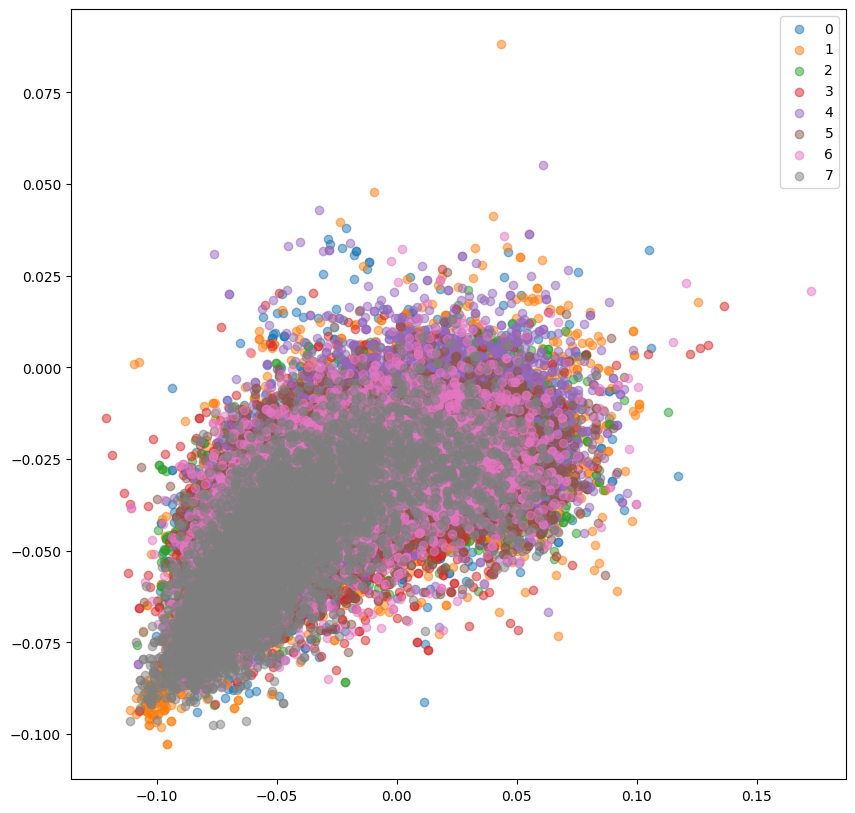

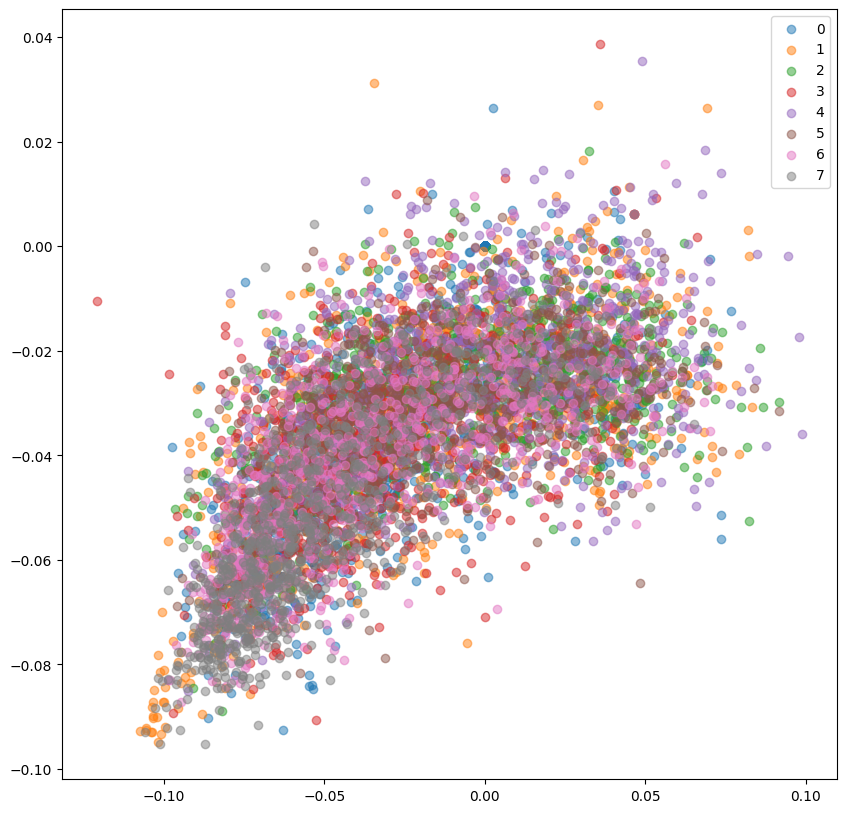

In [27]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = [ '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(8):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for songs, genre in dataloader:
            if cuda:
                songs = songs.cuda()
            embeddings[k:k+len(songs)] = model.get_embedding(songs).data.cpu().numpy()
            labels[k:k+len(songs)] = genre.numpy()
            k += len(songs)
    return embeddings, labels

def apply_pca(embeddings, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, perplexity=50, learning_rate=200, n_iter=3000, random_state=42)
    return tsne.fit_transform(embeddings)

train_embeddings_ocl, train_labels_ocl = extract_embeddings(audio_train_loader, simple_embedding_model)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(audio_val_loader, simple_embedding_model)

# train_embeddings_ocl = train_embeddings_ocl / np.linalg.norm(train_embeddings_ocl, axis=1, keepdims=True)
# val_embeddings_ocl = val_embeddings_ocl / np.linalg.norm(val_embeddings_ocl, axis=1, keepdims=True)

# train_embeddings_pca = apply_pca(train_embeddings_ocl)
# val_embeddings_pca = apply_pca(val_embeddings_ocl)

# train_embeddings_2d = apply_tsne(train_embeddings_pca)
# val_embeddings_2d = apply_tsne(val_embeddings_pca)

plot_embeddings(train_embeddings_ocl, train_labels_ocl)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

In [28]:
runtime.unassign()